In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Image Compression

In this challenge we will use **images** 🖼️ as data. 

You will use **K-means** for image compression, by reducing the colors in an image to only the most frequent ones.

## 1) Images with Python

This section should give you some understanding of how we deal with images in Python.  

**No coding required for section 1), read carefully and execute the examples provided.**

### 1.1) Black & white images

An image can be described as a matrix where each element is a pixel.  

The scale of colors is between 0 (black) and 255 (white).  

Thus, each element in the matrix will have a value between 0 and 255.

<img src="https://miro.medium.com/max/1386/1*bV7S0zACdidh11ikjYpLpQ.png">

We said `matrix`, you thought `numpy`, that's accurate 🙂  

👇 Execute the cell below to see a black and white image created only with `numpy`.

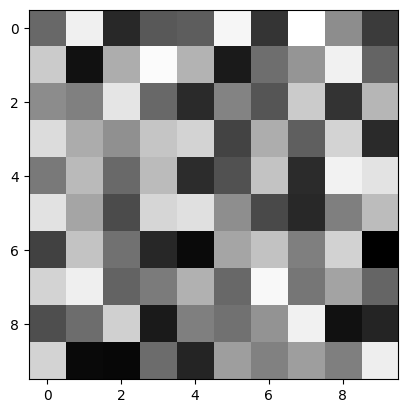

In [2]:
# Let's create  a vector of 100 elements with a value between 0 and 255
image_bw = np.random.uniform(low=0, high=255, size=100)

# Reshape it into a squared matrix, we have an image of 10x10 pixels
image_bw = image_bw.reshape((10, 10))

# Finally display the generated image
plt.imshow(image_bw, cmap='gray');

### 1.2) Colored images :

Every color is a linear combination of primary colors : Red, Green, Blue  

A colored image is just the overlay of three layers, one for each primary color.  

So for each pixel, we have three values (Red, Green, Blue).

<img src="https://miro.medium.com/max/840/1*y0nV4cWk3KbzXSe9dIWL5g.jpeg">

👇  Again, execute the cells below to see a colored image created only with `numpy`.

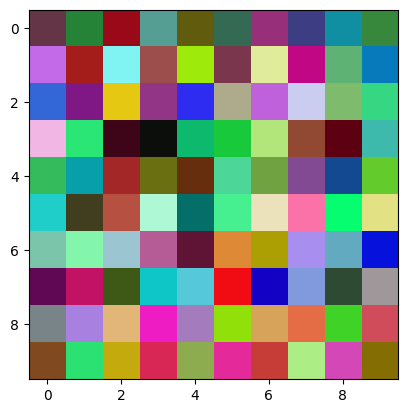

In [3]:
# Let's create vector of 100*3 elements with a value between 0 and 1
image_c = np.random.uniform(low=0., high=1., size=100*3)

# Reshape it into a squared image of 10x10 pixels with 3 colors
image_c = image_c.reshape((10, 10, 3))

# Finally display the generated image
plt.imshow(image_c);

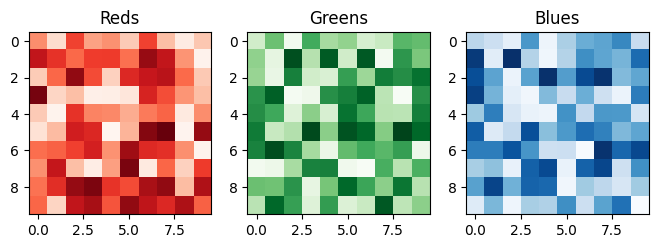

In [4]:
# To get some intuition, let's plot each color layer
fig, axs = plt.subplots(1, 3, figsize=(8, 6))
colors = {0:'Reds', 1:'Greens', 2:'Blues'}

for i in colors:
    axs[i].imshow(image_c[:, :, i], cmap=colors[i])
    axs[i].set_title(colors[i])

## 2) Images for ML

### 2.1) Setup

Install the `skimage` library, it will give us access to classic images

In [5]:
! pip install --quiet scikit-image

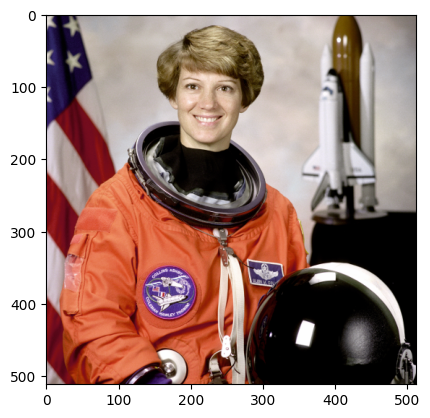

In [6]:
from skimage import data
img = data.astronaut()
plt.imshow(img);

❓ What is the shape of this image?  
Assign it to `img_shape`

In [9]:
# YOUR CODE HERE
img_shape = img.shape
print (img_shape)

(512, 512, 3)


### 2.2) Number of colors

To make our image ready for compression, or ML in general, we need to represent it as **observations** and **features**.  

Each **pixel** is an **observation**  
Each **color value (Red, Green, Blue)** is a **feature**  

In our image, we have **262,144 observations** (512 * 512 pixels) and **3 features** (RGB)

❓ Reshape the image:  
- From its current size of `width * height * 3`
- To a matrix  of size `N * 3` where `N = width * height`  

Assign the reshaped image to `X`.

In [17]:
# YOUR CODE HERE
#print(img)
X = np.reshape(img, (-1, 3))

print("Shape of X:", X.shape)

Shape of X: (262144, 3)


A colored image may contain up to 16 Millions potential colors.  

Indeed, for each pixel we have **3** channels, and for each channel we have **256** possible values (from 0 to 255)  
Hence a potential maximum of **16,777,216** *($256^3$)* colors in a colored image  

Since our image is only 262,144 pixels (512 * 512), it uses at most 262,144 colors, as each pixel contains a single color defined by the three channels' values

Let's count! 🕵️ 

❓ Store the number of unique colors in this picture in `color_count`

In [55]:
# YOUR CODE HERE
picture_df = pd.DataFrame(X)
#print(picture_df)

###Drop duplicates rows#####
unique_colors = picture_df.drop_duplicates()

###The count the length#####
color_count = len(unique_colors)

print("Number of unique colors in the image:", color_count)



Number of unique colors in the image: 113382


Let's break down what we have: 
- 262,144 observations, each observation is a pixel  
- 3 features (Red, Green & Blue values) for each observation
- An unknown number of clusters 😱

**Let's see what we can do to reduce the number of colors** 🎨

### 🧪 Test your code

In [35]:
from nbresult import ChallengeResult

result = ChallengeResult('image_analysis',
                         img_shape = img_shape,
                         color_count = color_count)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/Laetitia/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/Laetitia/code/juliensoudet/05-ML/06-Unsupervised-Learning/data-image-compression/tests
plugins: asyncio-0.19.0, typeguard-2.13.3, anyio-3.6.2
asyncio: mode=strict
collecting ... collected 2 items

test_image_analysis.py::TestImageAnalysis::test_color_count PASSED       [ 50%]
test_image_analysis.py::TestImageAnalysis::test_img_shape PASSED         [100%]

============================== 2 passed in 0.07s ===============================


💯 You can commit your code:

git add tests/image_analysis.pickle

git commit -m 'Completed image_analysis step'

git push origin master



In [36]:
! git add tests/image_analysis.pickle

! git commit -m 'Completed image_analysis step'

! git push origin master

[master 478dbf3] Completed image_analysis step
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 tests/image_analysis.pickle
Enumerating objects: 6, done.
Counting objects: 100% (6/6), done.
Delta compression using up to 4 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 474 bytes | 474.00 KiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To github.com:juliensoudet/data-image-compression.git
   04c20e2..478dbf3  master -> master


## 3) Compression with K-means

We want to reduce the **113,382** colors to **K** colors.  

Using a `KMeans` algorithm over the pixels, we can assign each pixel to one of **K** clusters!  

The center of each cluster is going to be the average color of the pixels that belong to it. 

We can then use this "mean cluster color" as the RGB values for each pixel in the cluster.  

💪🧠 Let's do it, our objective is to use only **32** colors!

❓ Fit a K-means with `n_clusters=32` on your ML-ready image `X`, and assign it to `kmeans`

In [38]:
# YOUR CODE HERE

X = picture_df

from sklearn.cluster import KMeans

# Fit K-means
km = KMeans(n_clusters=32)
km.fit(X)


KMeans(n_clusters=32)

👉 Check the `labels_` of your `kmeans`, then check their `shape` and `number of unique values`

In [47]:
# YOUR CODE HERE
labels = km.labels_
print(labels.shape)
print (labels)
number_of_unique_values = np.unique(labels).sum()

print("Unique values:", number_of_unique_values)


(262144,)
[31 27 18 ...  1  1  1]
Unique values: 496


☝️ Let's break it down:

- Each label is a cluster
- There is one label assigned to each observations
- There are a total of 32 different labels, one for each cluster

❓ Check the `cluster_centers_` of your `KMeans`, shape and first element

In [51]:
# YOUR CODE HERE
cluster_center = km.cluster_centers_
print (cluster_center.shape)
print (cluster_center[0])

(32, 3)
[133.04825164 124.10551229 122.98793709]


☝️Each cluster_center is a vector of RGB values, it represents the mean color of the cluster

❓ Create an array `X_compressed`, which stores for each pixel picture the mean color of its corresponding cluster.

<details span="markdown">
    <summary>💡 Help</summary>

You can achieve this by using only `kmeans.cluster_centers_` and `kmeans.labels_`

---

</details>

In [60]:
picture_array = picture_df.values

picture_flat = picture_array.reshape(-1, 3)

### Initialize X_compressed with zeros of the same shape as the original picture###
X_compressed = np.zeros_like(picture_flat)

# #Iterate through each pixel in the flat picture
for i in range(len(picture_flat)):
    label = km.labels_[i]
    X_compressed[i] = km.cluster_centers_[label]

X_compressed = X_compressed.reshape(picture_array.shape)

X_compressed




array([[155, 145, 143],
       [109, 100,  98],
       [ 49,  35,  91],
       ...,
       [  1,   0,   0],
       [  1,   0,   0],
       [  1,   0,   0]], dtype=uint8)

RGB values must be integer.  

Our colors in `X_compressed` are in `float64`.  

❓ Convert `X_compressed` to `uint8`, the unsigned 8-bits integer type which lies between 0 and 255.

In [ ]:
# YOUR CODE HERE

❓ Verify that the number of unique colors used is indeed 32.

In [63]:
# YOUR CODE HERE
X_compressed_df = pd.DataFrame(X_compressed)
X_compressed_df.drop_duplicates().count()

0    32
1    32
2    32
dtype: int64

Almost there! 💪

## 4) Plot compressed image

Our `X_compressed` has shape (262144, 3), we can't display it as an image.

❓ Reshape your compressed image and plot it side by side with your original image.  

<details>
    <summary>💡 Hint</summary>

You need to reshape your flattened `X_compressed` into the right dimensions for an image  
Your original image has such dimensions.

---

</details>

In [67]:
# YOUR CODE HERE
compressed_image = X_compressed.reshape(img.shape)

compressed_image


array([[[155, 145, 143],
        [109, 100,  98],
        [ 49,  35,  91],
        ...,
        [133, 124, 122],
        [109, 100,  98],
        [133, 124, 122]],

       [[186, 177, 173],
        [155, 145, 143],
        [133, 124, 122],
        ...,
        [133, 124, 122],
        [133, 124, 122],
        [109, 100,  98]],

       [[200, 191, 188],
        [186, 177, 173],
        [173, 164, 160],
        ...,
        [133, 124, 122],
        [133, 124, 122],
        [133, 124, 122]],

       ...,

       [[186, 177, 173],
        [186, 177, 173],
        [186, 177, 173],
        ...,
        [  1,   0,   0],
        [  1,   0,   0],
        [  1,   0,   0]],

       [[186, 177, 173],
        [186, 177, 173],
        [186, 177, 173],
        ...,
        [  1,   0,   0],
        [  1,   0,   0],
        [  1,   0,   0]],

       [[186, 177, 173],
        [173, 164, 160],
        [173, 164, 160],
        ...,
        [  1,   0,   0],
        [  1,   0,   0],
        [  1,   0,   0]]

Text(0.5, 1.0, 'Compressed Image')

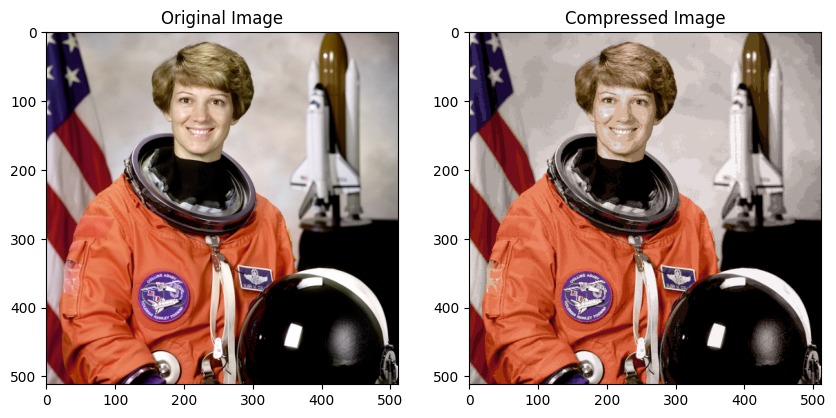

In [68]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')


plt.subplot(1, 2, 2)
plt.imshow(compressed_image)
plt.title('Compressed Image')

Well done! 💪

Some colors are lost, but your can easily recognize the original image.

🏁 **Don't forget to push your notebook.**  

Proceed with the challenges of the day and come back here if you have time 😉

In [72]:
! git add image_compression.ipynb

! git commit -m 'Completed compression step'

! git push origin master

[master 7a1beea] Completed compression step
 1 file changed, 845 insertions(+), 40 deletions(-)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 4 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 689.25 KiB | 5.99 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To github.com:juliensoudet/data-image-compression.git
   478dbf3..7a1beea  master -> master


## 5 - Optional) Use the elbow method

You can try to use the Elbow method to find the optimal compression that loses the least color information.   

Try to plot the `inertia` for `n_clusters` in the list [5, 10, 20, 30, 50, 70, 100] for instance  

⚠️ Long training, you might wait several minutes

In [ ]:
# YOUR CODE HERE

❓ Run the cell below to visualize your compressed image using different number of clusters  
⚠️ This is a long training, you will wait a few minutes

In [ ]:
wcss = []
compressed_astronaut = []
for i in [1, 2, 5, 10, 20, 30, 50, 70, 100]:
    print('working with ' + str(i) + ' clusters...', flush=True)
    kmeans = KMeans(n_clusters = i, max_iter=10)
    kmeans.fit(X)
    # compute inertia
    wcss.append(kmeans.inertia_)
    # compute compressed astronaut
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    X_compressed = centers[labels]
    X_compressed = X_compressed.astype('uint8')
    img_compressed = X_compressed.reshape(img_shape[0], img_shape[1], img_shape[2])
    compressed_astronaut.append(img_compressed)
    # printing
    print("-"*120)
    print(f"If we compress our 113382 unique colors into {i} clusters...")
    print(f"The Kmeans inertia is equal to {kmeans.inertia_}")
    fig, ax = plt.subplots(1, 2, figsize = (7, 7))
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[1].imshow(img_compressed)
    ax[1].set_title('Compressed Image')
    for ax in fig.axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()